## Sentiment Analysis with Tweepy

### Set up environment

In [ ]:
!pip install tweepy==4.9.0

In [ ]:
import tweepy
import pandas as pd
import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
import nltk
nltk.download('vader_lexicon')

import numpy as np
from PIL import Image
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


### Twitter Authentication

In [ ]:
#Put your Bearer Token in the parenthesis below
client = tweepy.Client(bearer_token='replace_me')

### Get recent public tweets on a keyword

In [ ]:
# Pull tweets from twitter

query = '#apple -is:retweet lang:en'
paginator = tweepy.Paginator(
    client.search_recent_tweets,           # The method you want to use
    query=query,                           # Some argument for this method
    max_results=100,                       # How many tweets per page
    limit=10                               # How many pages to retrieve
)
# Get tweets that contain the hashtag #TypeKeywordHere
# -is:retweet means I don't want retweets
# lang:en is asking for the tweets to be in english

tweet_list = []

for tweet in paginator.flatten(): # Total number of tweets to retrieve
    tweet_list.append(tweet)
    print(tweet)

In [ ]:
#Creating new dataframe and new features
tweet_list_df = pd.DataFrame(tweet_list)
tweet_list_df = pd.DataFrame(tweet_list_df['text'])
tweet_list_df.head(5)

### Data preprocessing

In [ ]:
def preprocess_tweet(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''

    sentence = sen.lower()

    # Remove RT
    sentence = re.sub('RT @\w+: '," ", sentence)

    # Remove special characters
    sentence = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ", sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    return sentence

In [ ]:
cleaned_tweets = []

for tweet in tweet_list_df['text']:
  cleaned_tweet = preprocess_tweet(tweet)
  cleaned_tweets.append(cleaned_tweet)

In [ ]:
tweet_list_df['cleaned'] = pd.DataFrame(cleaned_tweets)
tweet_list_df.head(5)

### Generate Sentiment Labels

In [ ]:
#Calculating Negative, Positive, Neutral and Compound values

tweet_list_df[['polarity', 'subjectivity']] = tweet_list_df['cleaned'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))
for index, row in tweet_list_df['cleaned'].iteritems():
    score = SentimentIntensityAnalyzer().polarity_scores(row)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
    if comp <= -0.05:
        tweet_list_df.loc[index, 'sentiment'] = "negative"
    elif comp >= 0.05:
        tweet_list_df.loc[index, 'sentiment'] = "positive"
    else:
        tweet_list_df.loc[index, 'sentiment'] = "neutral"
    tweet_list_df.loc[index, 'neg'] = neg
    tweet_list_df.loc[index, 'neu'] = neu
    tweet_list_df.loc[index, 'pos'] = pos
    tweet_list_df.loc[index, 'compound'] = comp

tweet_list_df.head(5)

### Sentiment Visualisation

In [ ]:
#Creating new data frames for all sentiments (positive, negative and neutral)

tweet_list_df_negative = tweet_list_df[tweet_list_df["sentiment"]=="negative"]
tweet_list_df_positive = tweet_list_df[tweet_list_df["sentiment"]=="positive"]
tweet_list_df_neutral = tweet_list_df[tweet_list_df["sentiment"]=="neutral"]

#### Donut Charts

In [ ]:
#Function for count_values_in single columns

def count_values_in_column(data,feature):
    total=data.loc[:,feature].value_counts(dropna=False)
    percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
    return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])

In [ ]:
#Count_values for sentiment
count_values_in_column(tweet_list_df,"sentiment")

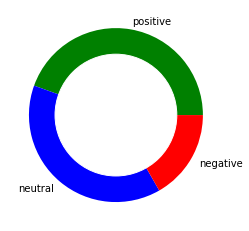

In [ ]:
# create data for Pie Chart
pichart = count_values_in_column(tweet_list_df,"sentiment")
# names= pc.index
# size=pc["Percentage"]

names= pichart.index
size=pichart["Percentage"]

# Create a circle for the center of the plot
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(size, labels=names, colors=['green','blue','red'])
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

#### Word Clouds

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive/1_LiveProjects/Project9_TwitterAPI_Sentiments
!ls

In [ ]:
#Function to Create Wordcloud

def create_wordcloud(text):
    mask = np.array(Image.open("./a1_inputs/cloud.png"))
    stopwords = set(STOPWORDS)
    wc = WordCloud(background_color="white",
                  mask = mask,
                  max_words=100,
                  stopwords=stopwords,
                  repeat=True)
    wc.generate(str(text))
    wc.to_file("c1_wordcloud.png")
    print("Word Cloud Saved Successfully")
    path="c1_wordcloud.png"
    display(Image.open(path))

In [ ]:
# Creating wordcloud for all tweets

create_wordcloud(tweet_list_df["cleaned"].values)
# create_wordcloud(tweet_list_df_positive["text"].values)
# create_wordcloud(tweet_list_df_negative["cleaned"].values)
# create_wordcloud(tweet_list_df_neutral["text"].values)

#### Text Insights

In [ ]:
#Calculating tweet's lenght and word count
tweet_list_df['text_len'] = tweet_list_df['cleaned'].astype(str).apply(len)
tweet_list_df['text_word_count'] = tweet_list_df['cleaned'].apply(lambda x: len(str(x).split()))

In [ ]:
round(pd.DataFrame(tweet_list_df.groupby("sentiment").text_len.mean()),2)

In [ ]:
round(pd.DataFrame(tweet_list_df.groupby("sentiment").text_word_count.mean()),2)

### Saving Output Tweets File to Drive

In [ ]:
tweet_list_df.to_csv("./c2_sentimentanalysis_output.csv", sep=',', encoding='UTF-8')
tweet_list_df.head(5)